In [1]:
#verif of order of SST - July 2021
#verif of restacking of product
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
from gsw import sigma0
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import colorcet as cc


import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

os.getcwd()
pathfig = '/home1/datawork/epauthen/Fig_Product/Figure_clean/'

#Mappign stuff
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([-78.7, -31, 23, 47])
subplot_kw = {'projection': proj, 'extent': extent}
#To get the bathymetry
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
ds_bat = ds_bat.where(ds_bat.LONGITUDE<(-40),-1500)
ds_bat = ds_bat.where(((ds_bat.LONGITUDE>(-68)) & (ds_bat.LATITUDE>(30)) & (ds_bat.LATITUDE<(40)))==False,-1500)
kw = {'levels':[-1000], 'colors':['black'],'linewidths':[.5],'linestyles':['solid']}

In [2]:
ds_cora = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA1000_1993-2019_coloc_v2.nc")
ds_cora

<xarray.Dataset>
Dimensions:            (N_PROF: 67767, PRES_INTERPOLATED: 51)
Coordinates:
    LONGITUDE          (N_PROF) float64 ...
    LATITUDE           (N_PROF) float64 ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
    TIME               (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables: (12/19)
    TEMP_SURF          (N_PROF, PRES_INTERPOLATED) float64 ...
    PSAL_SURF          (N_PROF, PRES_INTERPOLATED) float64 ...
    TEMP_INTERP        (N_PROF, PRES_INTERPOLATED) float64 ...
    PSAL_INTERP        (N_PROF, PRES_INTERPOLATED) float64 ...
    DC_REFERENCE       (N_PROF) |S8 ...
    PLATFORM_NUMBER    (N_PROF) |S8 ...
    ...                 ...
    UGOSA              (N_PROF) float64 ...
    VGOSA              (N_PROF) float64 ...
    SLA_err            (N_PROF) float64 ...
    SSS                (N_PROF) float32 ...
    SSS_random_error   (N_PROF) float32 ...
    SSS_bias           (N_PROF) float32 ...

In [3]:
x = ds_cora.LONGITUDE
y = ds_cora.LATITUDE
binx = np.arange(-78.5, -30, 0.25)
biny = np.arange(23, 50, 0.25)
biny
ret = stats.binned_statistic_2d( x, y, None, 'count', bins=[binx, biny], expand_binnumbers=True)

In [4]:
count = ret.statistic
count0 = count
count0[count==0]=np.nan
count0

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 7.,  7.,  3., ...,  3.,  5.,  3.],
       [ 4.,  5.,  6., ...,  5.,  6.,  3.],
       [ 1.,  4.,  2., ..., 13.,  4.,  4.]])

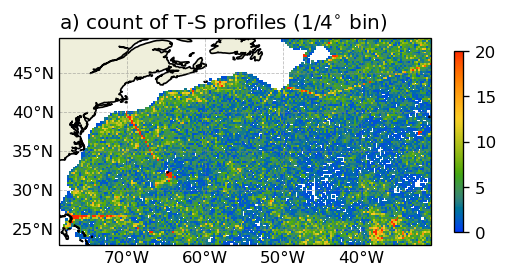

In [24]:
cm = cc.cm["rainbow"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
cf = ax.pcolormesh(np.arange(-78.5, -30.25, 0.25),np.arange(23.25, 50, 0.25), count.T, cmap = cm, vmin = 0,vmax = 20,shading='auto')
ax.add_feature(land_feature, edgecolor='black')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
fig.colorbar(cf, ax=ax,shrink=.4)
ax.set_title('a) count of T-S profiles (1/4$^{\circ}$ bin)',loc = 'left')
#ds_bat['bathymetry'].plot.contour(**kw,ax = ax)


plt.savefig(pathfig + 'Count1.png', transparent=False)

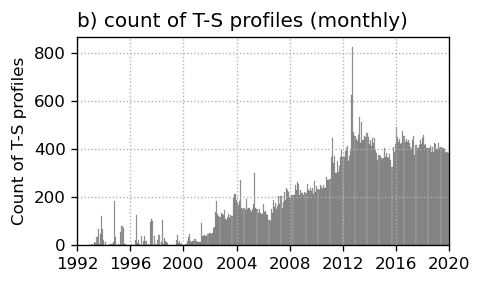

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2.3), dpi=120, facecolor='w', edgecolor='k')
sc = sns.histplot(ds_cora.TIME,ax = ax,bins = 329,color = 'grey')
ax.set_ylabel('Count of T-S profiles')
ax.set_xlim(['1992','2020'])
ax.grid(linestyle = 'dotted')
ax.set_title('b) count of T-S profiles (monthly)',loc = 'left')

plt.savefig(pathfig + 'Count2.png', transparent=False)

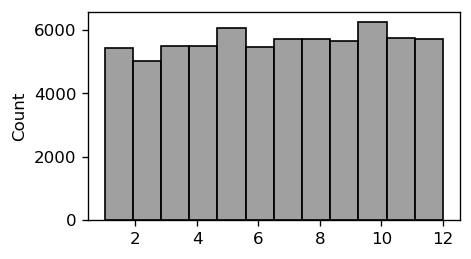

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2.3), dpi=120, facecolor='w', edgecolor='k')
sc = sns.histplot(ds_cora.TIME.dt.month,ax = ax,bins = 12,color = 'grey')

#ax.set_ylabel('Count of T-S profiles')
#ax.set_xlim(['1992','2020'])
#ax.grid(linestyle = 'dotted')
#ax.set_title('b) count of T-S profiles (monthly)',loc = 'left')

#plt.savefig(pathfig + 'Count3.png', transparent=False)

In [19]:
aa = ds_cora.groupby(ds_cora.TIME.dt.month)

In [28]:
for i in np.arange(1,13):
    print(len(aa[i].N_PROF))

5428
5027
5499
5490
6055
5457
5710
5713
5664
6257
5751
5716


In [35]:
#np.mean([5428,5027,5499,5490,6055,5457,5710,5713,5664,6257,5751,5716])
#np.std([5428,5027,5499,5490,6055,5457,5710,5713,5664,6257,5751,5716])
#np.min([5428,5027,5499,5490,6055,5457,5710,5713,5664,6257,5751,5716])
np.max([5428,5027,5499,5490,6055,5457,5710,5713,5664,6257,5751,5716])


6257

In [ ]:
#5647 +-300
#5027 to 6257


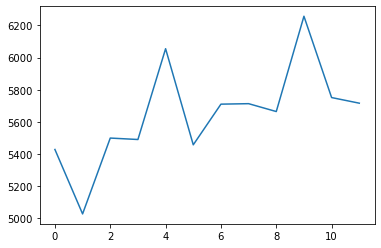

In [36]:
plt.plot([5428,5027,5499,5490,6055,5457,5710,5713,5664,6257,5751,5716])

In [42]:

for yy in np.arange(1993,2019):
    aa = ds_cora.where(ds_cora.TIME.dt.year==yy,drop = True).groupby(ds_cora.TIME.dt.month)
    for i in np.arange(1,12):
        print(len(aa[i].N_PROF))
    

ValueError: the group variable's length does not match the length of this variable along its dimension